In [369]:
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import lightgbm as lgb
import datetime as dt
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [401]:
borrar = ["Opportunity_Name", "ID", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "Actual_Delivery_Date", "Last_Activity", 
          "ASP_converted_Currency", "Prod_Category_A", "Product_Name", "Delivery_Year", 
          "TRF", "Product_Family", "Account_Name"]

useless = ["Submitted_for_Approval", "Account_Type", "Delivery_Terms", "Size", "Price", "ASP_Currency", 
           "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type"]

dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date"]

target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [402]:
def preprocess(data):
    
    # elimino caracteres prohibidos en los headers
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days
    data["Same_Owner"] = (data.Opportunity_Owner == data.Account_Owner) & (data.Opportunity_Owner == data.Last_Modified_By)
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    data.loc[data.TRF == 0, "TRF_Cat"] = 0
    data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    data.loc[data.TRF > 7, "TRF_Cat"] = 2
    data["Sales"] = data.groupby("Account_Name", sort=False)["Opportunity_ID"].transform(lambda x: x.nunique())
    
    data["Concrete_Offer"] = (data["Planned_Delivery_End_Date"] - data["Opportunity_Created_Date"]).dt.days
    data["Offer_Duration"] = (data["Quote_Expiry_Date"] - data["Opportunity_Created_Date"]).dt.days
    
    # fabri
    
    data["Territory_Defined"] = data.Territory != "None"
    data["Past_Quote"] = (data["Last_Modified_Date"] - data["Quote_Expiry_Date"]).dt.days
    data["Month"] = data.Month.str[-2:].astype(int)
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype('category')
        
    # limpio columnas
    
    data = data.drop(borrar + useless + dates + ["Delivery_Quarter"], axis = 1)
    
    #data.drop(data[(data.Contacts > 1) & (data.ASP.isna())].index, inplace = True)
    #data = data.drop_duplicates([x for x in data.columns if x != 'ID'])
    
    return (data)

In [372]:
import catboost as ctb

In [403]:
data = pd.read_csv("Entrenamieto_ECI_2020.csv")

In [404]:
prep = preprocess(data)

In [405]:
prep = prep[(prep.Stage == "Closed Won") | (prep.Stage == "Closed Lost")]
prep.Stage = prep.Stage.replace({"Closed Won": 1, "Closed Lost": 0})

In [406]:
x_train, x_test, y_train, y_test = train_test_split(prep, prep.Stage, test_size=0.3, random_state=0)

In [407]:
cat_vars = [x for x in x_train.drop(target, axis=1).select_dtypes('category').columns if x != 'Stage']

In [408]:
cat_indexes = [x_train.drop(target, axis=1).columns.get_loc(x) for x in cat_vars]

In [409]:
model = ctb.CatBoostClassifier(num_boost_round=5000,
                               learning_rate=0.015,
                               l2_leaf_reg=3.5,
                               depth=8, 
                               max_bin=400,
                               num_leaves=31,
                               rsm=0.98,
                               eval_metric='Logloss',
                               use_best_model=True,
                               random_seed=42)

In [410]:
model.fit(x_train.drop(target, axis=1), y_train, eval_set=(x_test.drop(target, axis=1), y_test), cat_features=cat_indexes, early_stopping_rounds=800)

0:	learn: 0.6680970	test: 0.6683640	best: 0.6683640 (0)	total: 16.8ms	remaining: 1m 24s
1:	learn: 0.6449479	test: 0.6455436	best: 0.6455436 (1)	total: 32.9ms	remaining: 1m 22s
2:	learn: 0.6206202	test: 0.6215546	best: 0.6215546 (2)	total: 46.7ms	remaining: 1m 17s
3:	learn: 0.6012771	test: 0.6024262	best: 0.6024262 (3)	total: 51ms	remaining: 1m 3s
4:	learn: 0.5818049	test: 0.5832843	best: 0.5832843 (4)	total: 60.3ms	remaining: 1m
5:	learn: 0.5614725	test: 0.5632756	best: 0.5632756 (5)	total: 68ms	remaining: 56.6s
6:	learn: 0.5425787	test: 0.5445139	best: 0.5445139 (6)	total: 83.3ms	remaining: 59.4s
7:	learn: 0.5244934	test: 0.5266269	best: 0.5266269 (7)	total: 98.8ms	remaining: 1m 1s
8:	learn: 0.5063236	test: 0.5087699	best: 0.5087699 (8)	total: 116ms	remaining: 1m 4s
9:	learn: 0.4893942	test: 0.4921560	best: 0.4921560 (9)	total: 134ms	remaining: 1m 7s
10:	learn: 0.4740256	test: 0.4770254	best: 0.4770254 (10)	total: 150ms	remaining: 1m 8s
11:	learn: 0.4601428	test: 0.4632792	best: 0.463

100:	learn: 0.1181970	test: 0.1300993	best: 0.1300993 (100)	total: 1.71s	remaining: 1m 23s
101:	learn: 0.1175289	test: 0.1295074	best: 0.1295074 (101)	total: 1.74s	remaining: 1m 23s
102:	learn: 0.1168767	test: 0.1289403	best: 0.1289403 (102)	total: 1.76s	remaining: 1m 23s
103:	learn: 0.1162889	test: 0.1284389	best: 0.1284389 (103)	total: 1.78s	remaining: 1m 24s
104:	learn: 0.1155647	test: 0.1278348	best: 0.1278348 (104)	total: 1.81s	remaining: 1m 24s
105:	learn: 0.1150035	test: 0.1272770	best: 0.1272770 (105)	total: 1.83s	remaining: 1m 24s
106:	learn: 0.1142419	test: 0.1265670	best: 0.1265670 (106)	total: 1.84s	remaining: 1m 24s
107:	learn: 0.1138008	test: 0.1261480	best: 0.1261480 (107)	total: 1.87s	remaining: 1m 24s
108:	learn: 0.1131357	test: 0.1255699	best: 0.1255699 (108)	total: 1.89s	remaining: 1m 24s
109:	learn: 0.1125311	test: 0.1250526	best: 0.1250526 (109)	total: 1.92s	remaining: 1m 25s
110:	learn: 0.1119596	test: 0.1245960	best: 0.1245960 (110)	total: 1.94s	remaining: 1m 25s

196:	learn: 0.0878431	test: 0.1032674	best: 0.1032674 (196)	total: 3.6s	remaining: 1m 27s
197:	learn: 0.0874406	test: 0.1029122	best: 0.1029122 (197)	total: 3.62s	remaining: 1m 27s
198:	learn: 0.0872215	test: 0.1027784	best: 0.1027784 (198)	total: 3.64s	remaining: 1m 27s
199:	learn: 0.0870690	test: 0.1026803	best: 0.1026803 (199)	total: 3.65s	remaining: 1m 27s
200:	learn: 0.0870497	test: 0.1026586	best: 0.1026586 (200)	total: 3.66s	remaining: 1m 27s
201:	learn: 0.0867241	test: 0.1023679	best: 0.1023679 (201)	total: 3.68s	remaining: 1m 27s
202:	learn: 0.0865705	test: 0.1022474	best: 0.1022474 (202)	total: 3.69s	remaining: 1m 27s
203:	learn: 0.0863851	test: 0.1020760	best: 0.1020760 (203)	total: 3.71s	remaining: 1m 27s
204:	learn: 0.0861867	test: 0.1019205	best: 0.1019205 (204)	total: 3.73s	remaining: 1m 27s
205:	learn: 0.0860754	test: 0.1018485	best: 0.1018485 (205)	total: 3.74s	remaining: 1m 27s
206:	learn: 0.0859412	test: 0.1017707	best: 0.1017707 (206)	total: 3.76s	remaining: 1m 27s


287:	learn: 0.0752509	test: 0.0936659	best: 0.0936659 (287)	total: 5.29s	remaining: 1m 26s
288:	learn: 0.0750460	test: 0.0934984	best: 0.0934984 (288)	total: 5.32s	remaining: 1m 26s
289:	learn: 0.0749644	test: 0.0934477	best: 0.0934477 (289)	total: 5.34s	remaining: 1m 26s
290:	learn: 0.0749112	test: 0.0933968	best: 0.0933968 (290)	total: 5.37s	remaining: 1m 26s
291:	learn: 0.0748080	test: 0.0933192	best: 0.0933192 (291)	total: 5.39s	remaining: 1m 26s
292:	learn: 0.0746273	test: 0.0931567	best: 0.0931567 (292)	total: 5.41s	remaining: 1m 26s
293:	learn: 0.0745126	test: 0.0930584	best: 0.0930584 (293)	total: 5.42s	remaining: 1m 26s
294:	learn: 0.0744255	test: 0.0929428	best: 0.0929428 (294)	total: 5.44s	remaining: 1m 26s
295:	learn: 0.0743354	test: 0.0928386	best: 0.0928386 (295)	total: 5.46s	remaining: 1m 26s
296:	learn: 0.0742028	test: 0.0927688	best: 0.0927688 (296)	total: 5.47s	remaining: 1m 26s
297:	learn: 0.0741776	test: 0.0927498	best: 0.0927498 (297)	total: 5.49s	remaining: 1m 26s

387:	learn: 0.0667493	test: 0.0877150	best: 0.0877150 (387)	total: 7.17s	remaining: 1m 25s
388:	learn: 0.0667070	test: 0.0876733	best: 0.0876733 (388)	total: 7.19s	remaining: 1m 25s
389:	learn: 0.0665481	test: 0.0876148	best: 0.0876148 (389)	total: 7.2s	remaining: 1m 25s
390:	learn: 0.0665032	test: 0.0875806	best: 0.0875806 (390)	total: 7.22s	remaining: 1m 25s
391:	learn: 0.0664487	test: 0.0875580	best: 0.0875580 (391)	total: 7.24s	remaining: 1m 25s
392:	learn: 0.0663702	test: 0.0875423	best: 0.0875423 (392)	total: 7.26s	remaining: 1m 25s
393:	learn: 0.0663166	test: 0.0875040	best: 0.0875040 (393)	total: 7.28s	remaining: 1m 25s
394:	learn: 0.0662907	test: 0.0874871	best: 0.0874871 (394)	total: 7.3s	remaining: 1m 25s
395:	learn: 0.0661431	test: 0.0873825	best: 0.0873825 (395)	total: 7.33s	remaining: 1m 25s
396:	learn: 0.0660415	test: 0.0873405	best: 0.0873405 (396)	total: 7.35s	remaining: 1m 25s
397:	learn: 0.0660008	test: 0.0873219	best: 0.0873219 (397)	total: 7.38s	remaining: 1m 25s
3

487:	learn: 0.0607977	test: 0.0840585	best: 0.0840585 (487)	total: 8.87s	remaining: 1m 21s
488:	learn: 0.0607477	test: 0.0840591	best: 0.0840585 (487)	total: 8.88s	remaining: 1m 21s
489:	learn: 0.0607106	test: 0.0840398	best: 0.0840398 (489)	total: 8.9s	remaining: 1m 21s
490:	learn: 0.0606896	test: 0.0840296	best: 0.0840296 (490)	total: 8.92s	remaining: 1m 21s
491:	learn: 0.0606250	test: 0.0840016	best: 0.0840016 (491)	total: 8.93s	remaining: 1m 21s
492:	learn: 0.0605830	test: 0.0839772	best: 0.0839772 (492)	total: 8.95s	remaining: 1m 21s
493:	learn: 0.0605797	test: 0.0839725	best: 0.0839725 (493)	total: 8.95s	remaining: 1m 21s
494:	learn: 0.0604833	test: 0.0838877	best: 0.0838877 (494)	total: 8.97s	remaining: 1m 21s
495:	learn: 0.0604312	test: 0.0838813	best: 0.0838813 (495)	total: 8.98s	remaining: 1m 21s
496:	learn: 0.0603267	test: 0.0838668	best: 0.0838668 (496)	total: 9.01s	remaining: 1m 21s
497:	learn: 0.0602330	test: 0.0838121	best: 0.0838121 (497)	total: 9.03s	remaining: 1m 21s


585:	learn: 0.0554829	test: 0.0806052	best: 0.0806052 (585)	total: 10.8s	remaining: 1m 21s
586:	learn: 0.0554771	test: 0.0805977	best: 0.0805977 (586)	total: 10.8s	remaining: 1m 21s
587:	learn: 0.0554206	test: 0.0805462	best: 0.0805462 (587)	total: 10.8s	remaining: 1m 21s
588:	learn: 0.0553171	test: 0.0805415	best: 0.0805415 (588)	total: 10.8s	remaining: 1m 21s
589:	learn: 0.0552173	test: 0.0805018	best: 0.0805018 (589)	total: 10.9s	remaining: 1m 21s
590:	learn: 0.0551954	test: 0.0804766	best: 0.0804766 (590)	total: 10.9s	remaining: 1m 21s
591:	learn: 0.0551605	test: 0.0804464	best: 0.0804464 (591)	total: 10.9s	remaining: 1m 21s
592:	learn: 0.0550687	test: 0.0804053	best: 0.0804053 (592)	total: 10.9s	remaining: 1m 21s
593:	learn: 0.0550493	test: 0.0804057	best: 0.0804053 (592)	total: 10.9s	remaining: 1m 21s
594:	learn: 0.0549956	test: 0.0803741	best: 0.0803741 (594)	total: 11s	remaining: 1m 21s
595:	learn: 0.0548786	test: 0.0802593	best: 0.0802593 (595)	total: 11s	remaining: 1m 21s
596

681:	learn: 0.0509895	test: 0.0776954	best: 0.0776954 (681)	total: 12.7s	remaining: 1m 20s
682:	learn: 0.0509136	test: 0.0776597	best: 0.0776597 (682)	total: 12.7s	remaining: 1m 20s
683:	learn: 0.0508786	test: 0.0776416	best: 0.0776416 (683)	total: 12.7s	remaining: 1m 20s
684:	learn: 0.0508422	test: 0.0776110	best: 0.0776110 (684)	total: 12.7s	remaining: 1m 20s
685:	learn: 0.0508181	test: 0.0775920	best: 0.0775920 (685)	total: 12.7s	remaining: 1m 20s
686:	learn: 0.0507807	test: 0.0775650	best: 0.0775650 (686)	total: 12.8s	remaining: 1m 20s
687:	learn: 0.0507666	test: 0.0775554	best: 0.0775554 (687)	total: 12.8s	remaining: 1m 20s
688:	learn: 0.0507084	test: 0.0775312	best: 0.0775312 (688)	total: 12.8s	remaining: 1m 20s
689:	learn: 0.0506860	test: 0.0775267	best: 0.0775267 (689)	total: 12.8s	remaining: 1m 20s
690:	learn: 0.0506411	test: 0.0775152	best: 0.0775152 (690)	total: 12.9s	remaining: 1m 20s
691:	learn: 0.0505410	test: 0.0774770	best: 0.0774770 (691)	total: 12.9s	remaining: 1m 20s

776:	learn: 0.0464073	test: 0.0747786	best: 0.0747786 (776)	total: 14.8s	remaining: 1m 20s
777:	learn: 0.0463368	test: 0.0747003	best: 0.0747003 (777)	total: 14.8s	remaining: 1m 20s
778:	learn: 0.0462852	test: 0.0746465	best: 0.0746465 (778)	total: 14.8s	remaining: 1m 20s
779:	learn: 0.0462201	test: 0.0745886	best: 0.0745886 (779)	total: 14.8s	remaining: 1m 20s
780:	learn: 0.0461764	test: 0.0745327	best: 0.0745327 (780)	total: 14.9s	remaining: 1m 20s
781:	learn: 0.0461418	test: 0.0745002	best: 0.0745002 (781)	total: 14.9s	remaining: 1m 20s
782:	learn: 0.0461095	test: 0.0744905	best: 0.0744905 (782)	total: 14.9s	remaining: 1m 20s
783:	learn: 0.0459897	test: 0.0744094	best: 0.0744094 (783)	total: 14.9s	remaining: 1m 20s
784:	learn: 0.0459798	test: 0.0744003	best: 0.0744003 (784)	total: 14.9s	remaining: 1m 20s
785:	learn: 0.0459541	test: 0.0743784	best: 0.0743784 (785)	total: 15s	remaining: 1m 20s
786:	learn: 0.0459200	test: 0.0743560	best: 0.0743560 (786)	total: 15s	remaining: 1m 20s
787

871:	learn: 0.0429311	test: 0.0725224	best: 0.0725201 (868)	total: 16.7s	remaining: 1m 18s
872:	learn: 0.0429027	test: 0.0724937	best: 0.0724937 (872)	total: 16.7s	remaining: 1m 18s
873:	learn: 0.0428777	test: 0.0724812	best: 0.0724812 (873)	total: 16.7s	remaining: 1m 18s
874:	learn: 0.0428696	test: 0.0724708	best: 0.0724708 (874)	total: 16.7s	remaining: 1m 18s
875:	learn: 0.0428257	test: 0.0724339	best: 0.0724339 (875)	total: 16.8s	remaining: 1m 18s
876:	learn: 0.0427973	test: 0.0724401	best: 0.0724339 (875)	total: 16.8s	remaining: 1m 18s
877:	learn: 0.0427729	test: 0.0724399	best: 0.0724339 (875)	total: 16.8s	remaining: 1m 18s
878:	learn: 0.0426664	test: 0.0723620	best: 0.0723620 (878)	total: 16.8s	remaining: 1m 18s
879:	learn: 0.0426431	test: 0.0723601	best: 0.0723601 (879)	total: 16.8s	remaining: 1m 18s
880:	learn: 0.0426003	test: 0.0723512	best: 0.0723512 (880)	total: 16.9s	remaining: 1m 18s
881:	learn: 0.0425745	test: 0.0723180	best: 0.0723180 (881)	total: 16.9s	remaining: 1m 18s

971:	learn: 0.0397987	test: 0.0707995	best: 0.0707995 (971)	total: 18.5s	remaining: 1m 16s
972:	learn: 0.0397726	test: 0.0708136	best: 0.0707995 (971)	total: 18.5s	remaining: 1m 16s
973:	learn: 0.0396861	test: 0.0707665	best: 0.0707665 (973)	total: 18.6s	remaining: 1m 16s
974:	learn: 0.0396307	test: 0.0707330	best: 0.0707330 (974)	total: 18.6s	remaining: 1m 16s
975:	learn: 0.0396007	test: 0.0707192	best: 0.0707192 (975)	total: 18.6s	remaining: 1m 16s
976:	learn: 0.0395635	test: 0.0707134	best: 0.0707134 (976)	total: 18.6s	remaining: 1m 16s
977:	learn: 0.0395491	test: 0.0706971	best: 0.0706971 (977)	total: 18.6s	remaining: 1m 16s
978:	learn: 0.0394966	test: 0.0706619	best: 0.0706619 (978)	total: 18.7s	remaining: 1m 16s
979:	learn: 0.0394771	test: 0.0706466	best: 0.0706466 (979)	total: 18.7s	remaining: 1m 16s
980:	learn: 0.0393718	test: 0.0705554	best: 0.0705554 (980)	total: 18.7s	remaining: 1m 16s
981:	learn: 0.0393332	test: 0.0705258	best: 0.0705258 (981)	total: 18.7s	remaining: 1m 16s

1067:	learn: 0.0372155	test: 0.0692561	best: 0.0692561 (1067)	total: 20.2s	remaining: 1m 14s
1068:	learn: 0.0371957	test: 0.0692476	best: 0.0692476 (1068)	total: 20.2s	remaining: 1m 14s
1069:	learn: 0.0371896	test: 0.0692449	best: 0.0692449 (1069)	total: 20.2s	remaining: 1m 14s
1070:	learn: 0.0371783	test: 0.0692339	best: 0.0692339 (1070)	total: 20.2s	remaining: 1m 14s
1071:	learn: 0.0371355	test: 0.0692202	best: 0.0692202 (1071)	total: 20.3s	remaining: 1m 14s
1072:	learn: 0.0371309	test: 0.0692212	best: 0.0692202 (1071)	total: 20.3s	remaining: 1m 14s
1073:	learn: 0.0371014	test: 0.0692064	best: 0.0692064 (1073)	total: 20.3s	remaining: 1m 14s
1074:	learn: 0.0370386	test: 0.0691438	best: 0.0691438 (1074)	total: 20.3s	remaining: 1m 14s
1075:	learn: 0.0370197	test: 0.0691504	best: 0.0691438 (1074)	total: 20.3s	remaining: 1m 14s
1076:	learn: 0.0370036	test: 0.0691534	best: 0.0691438 (1074)	total: 20.3s	remaining: 1m 14s
1077:	learn: 0.0369837	test: 0.0691230	best: 0.0691230 (1077)	total: 2

1161:	learn: 0.0350109	test: 0.0680785	best: 0.0680785 (1161)	total: 22.1s	remaining: 1m 12s
1162:	learn: 0.0349997	test: 0.0680600	best: 0.0680600 (1162)	total: 22.1s	remaining: 1m 12s
1163:	learn: 0.0349581	test: 0.0680505	best: 0.0680505 (1163)	total: 22.1s	remaining: 1m 12s
1164:	learn: 0.0349491	test: 0.0680393	best: 0.0680393 (1164)	total: 22.1s	remaining: 1m 12s
1165:	learn: 0.0349231	test: 0.0680233	best: 0.0680233 (1165)	total: 22.2s	remaining: 1m 12s
1166:	learn: 0.0349038	test: 0.0680217	best: 0.0680217 (1166)	total: 22.2s	remaining: 1m 12s
1167:	learn: 0.0348663	test: 0.0680210	best: 0.0680210 (1167)	total: 22.2s	remaining: 1m 12s
1168:	learn: 0.0348563	test: 0.0680208	best: 0.0680208 (1168)	total: 22.2s	remaining: 1m 12s
1169:	learn: 0.0348258	test: 0.0680018	best: 0.0680018 (1169)	total: 22.2s	remaining: 1m 12s
1170:	learn: 0.0347679	test: 0.0679696	best: 0.0679696 (1170)	total: 22.3s	remaining: 1m 12s
1171:	learn: 0.0347380	test: 0.0679486	best: 0.0679486 (1171)	total: 2

1251:	learn: 0.0329332	test: 0.0670207	best: 0.0670207 (1251)	total: 23.7s	remaining: 1m 11s
1252:	learn: 0.0328857	test: 0.0669919	best: 0.0669919 (1252)	total: 23.8s	remaining: 1m 11s
1253:	learn: 0.0328621	test: 0.0669873	best: 0.0669873 (1253)	total: 23.8s	remaining: 1m 11s
1254:	learn: 0.0328515	test: 0.0669875	best: 0.0669873 (1253)	total: 23.8s	remaining: 1m 11s
1255:	learn: 0.0328485	test: 0.0669871	best: 0.0669871 (1255)	total: 23.8s	remaining: 1m 10s
1256:	learn: 0.0328104	test: 0.0669770	best: 0.0669770 (1256)	total: 23.8s	remaining: 1m 10s
1257:	learn: 0.0327751	test: 0.0669436	best: 0.0669436 (1257)	total: 23.8s	remaining: 1m 10s
1258:	learn: 0.0327451	test: 0.0669187	best: 0.0669187 (1258)	total: 23.9s	remaining: 1m 10s
1259:	learn: 0.0327375	test: 0.0669071	best: 0.0669071 (1259)	total: 23.9s	remaining: 1m 10s
1260:	learn: 0.0327334	test: 0.0669057	best: 0.0669057 (1260)	total: 23.9s	remaining: 1m 10s
1261:	learn: 0.0326957	test: 0.0668791	best: 0.0668791 (1261)	total: 2

1343:	learn: 0.0310582	test: 0.0660409	best: 0.0660409 (1343)	total: 25.4s	remaining: 1m 9s
1344:	learn: 0.0310512	test: 0.0660415	best: 0.0660409 (1343)	total: 25.4s	remaining: 1m 9s
1345:	learn: 0.0310269	test: 0.0660360	best: 0.0660360 (1345)	total: 25.5s	remaining: 1m 9s
1346:	learn: 0.0309767	test: 0.0660245	best: 0.0660245 (1346)	total: 25.5s	remaining: 1m 9s
1347:	learn: 0.0309512	test: 0.0660199	best: 0.0660199 (1347)	total: 25.5s	remaining: 1m 9s
1348:	learn: 0.0309398	test: 0.0660225	best: 0.0660199 (1347)	total: 25.5s	remaining: 1m 9s
1349:	learn: 0.0309239	test: 0.0660120	best: 0.0660120 (1349)	total: 25.5s	remaining: 1m 9s
1350:	learn: 0.0308982	test: 0.0660177	best: 0.0660120 (1349)	total: 25.5s	remaining: 1m 9s
1351:	learn: 0.0308556	test: 0.0659851	best: 0.0659851 (1351)	total: 25.6s	remaining: 1m 8s
1352:	learn: 0.0308400	test: 0.0659846	best: 0.0659846 (1352)	total: 25.6s	remaining: 1m 8s
1353:	learn: 0.0308238	test: 0.0659775	best: 0.0659775 (1353)	total: 25.6s	remai

1439:	learn: 0.0292323	test: 0.0652575	best: 0.0652575 (1439)	total: 27.1s	remaining: 1m 6s
1440:	learn: 0.0291978	test: 0.0652631	best: 0.0652575 (1439)	total: 27.1s	remaining: 1m 6s
1441:	learn: 0.0291902	test: 0.0652611	best: 0.0652575 (1439)	total: 27.1s	remaining: 1m 6s
1442:	learn: 0.0291667	test: 0.0652331	best: 0.0652331 (1442)	total: 27.1s	remaining: 1m 6s
1443:	learn: 0.0291642	test: 0.0652334	best: 0.0652331 (1442)	total: 27.1s	remaining: 1m 6s
1444:	learn: 0.0291492	test: 0.0652196	best: 0.0652196 (1444)	total: 27.2s	remaining: 1m 6s
1445:	learn: 0.0291325	test: 0.0652255	best: 0.0652196 (1444)	total: 27.2s	remaining: 1m 6s
1446:	learn: 0.0291261	test: 0.0652246	best: 0.0652196 (1444)	total: 27.2s	remaining: 1m 6s
1447:	learn: 0.0291043	test: 0.0652188	best: 0.0652188 (1447)	total: 27.2s	remaining: 1m 6s
1448:	learn: 0.0290821	test: 0.0652118	best: 0.0652118 (1448)	total: 27.2s	remaining: 1m 6s
1449:	learn: 0.0290439	test: 0.0651827	best: 0.0651827 (1449)	total: 27.2s	remai

1535:	learn: 0.0275022	test: 0.0644685	best: 0.0644685 (1535)	total: 28.7s	remaining: 1m 4s
1536:	learn: 0.0274992	test: 0.0644643	best: 0.0644643 (1536)	total: 28.8s	remaining: 1m 4s
1537:	learn: 0.0274956	test: 0.0644616	best: 0.0644616 (1537)	total: 28.8s	remaining: 1m 4s
1538:	learn: 0.0274926	test: 0.0644606	best: 0.0644606 (1538)	total: 28.8s	remaining: 1m 4s
1539:	learn: 0.0274890	test: 0.0644609	best: 0.0644606 (1538)	total: 28.8s	remaining: 1m 4s
1540:	learn: 0.0274696	test: 0.0644570	best: 0.0644570 (1540)	total: 28.8s	remaining: 1m 4s
1541:	learn: 0.0274457	test: 0.0644257	best: 0.0644257 (1541)	total: 28.9s	remaining: 1m 4s
1542:	learn: 0.0274344	test: 0.0644262	best: 0.0644257 (1541)	total: 28.9s	remaining: 1m 4s
1543:	learn: 0.0274151	test: 0.0644221	best: 0.0644221 (1543)	total: 28.9s	remaining: 1m 4s
1544:	learn: 0.0274016	test: 0.0644079	best: 0.0644079 (1544)	total: 28.9s	remaining: 1m 4s
1545:	learn: 0.0273958	test: 0.0644058	best: 0.0644058 (1545)	total: 29s	remaini

1632:	learn: 0.0260355	test: 0.0638108	best: 0.0638108 (1632)	total: 30.6s	remaining: 1m 3s
1633:	learn: 0.0260132	test: 0.0638068	best: 0.0638068 (1633)	total: 30.7s	remaining: 1m 3s
1634:	learn: 0.0259654	test: 0.0637932	best: 0.0637932 (1634)	total: 30.7s	remaining: 1m 3s
1635:	learn: 0.0259315	test: 0.0637635	best: 0.0637635 (1635)	total: 30.7s	remaining: 1m 3s
1636:	learn: 0.0259129	test: 0.0637457	best: 0.0637457 (1636)	total: 30.7s	remaining: 1m 3s
1637:	learn: 0.0259085	test: 0.0637449	best: 0.0637449 (1637)	total: 30.7s	remaining: 1m 3s
1638:	learn: 0.0259045	test: 0.0637442	best: 0.0637442 (1638)	total: 30.8s	remaining: 1m 3s
1639:	learn: 0.0258814	test: 0.0637331	best: 0.0637331 (1639)	total: 30.8s	remaining: 1m 3s
1640:	learn: 0.0258587	test: 0.0637229	best: 0.0637229 (1640)	total: 30.8s	remaining: 1m 3s
1641:	learn: 0.0258568	test: 0.0637228	best: 0.0637228 (1641)	total: 30.8s	remaining: 1m 3s
1642:	learn: 0.0258532	test: 0.0637166	best: 0.0637166 (1642)	total: 30.8s	remai

1724:	learn: 0.0247281	test: 0.0632840	best: 0.0632840 (1724)	total: 32.3s	remaining: 1m 1s
1725:	learn: 0.0247057	test: 0.0632777	best: 0.0632777 (1725)	total: 32.3s	remaining: 1m 1s
1726:	learn: 0.0247029	test: 0.0632771	best: 0.0632771 (1726)	total: 32.3s	remaining: 1m 1s
1727:	learn: 0.0246416	test: 0.0632301	best: 0.0632301 (1727)	total: 32.4s	remaining: 1m 1s
1728:	learn: 0.0246262	test: 0.0632294	best: 0.0632294 (1728)	total: 32.4s	remaining: 1m 1s
1729:	learn: 0.0246078	test: 0.0632235	best: 0.0632235 (1729)	total: 32.4s	remaining: 1m 1s
1730:	learn: 0.0246022	test: 0.0632123	best: 0.0632123 (1730)	total: 32.4s	remaining: 1m 1s
1731:	learn: 0.0245914	test: 0.0632154	best: 0.0632123 (1730)	total: 32.4s	remaining: 1m 1s
1732:	learn: 0.0245686	test: 0.0632097	best: 0.0632097 (1732)	total: 32.5s	remaining: 1m 1s
1733:	learn: 0.0245556	test: 0.0632071	best: 0.0632071 (1733)	total: 32.5s	remaining: 1m 1s
1734:	learn: 0.0245439	test: 0.0632112	best: 0.0632071 (1733)	total: 32.5s	remai

1826:	learn: 0.0232322	test: 0.0626669	best: 0.0626669 (1826)	total: 34.2s	remaining: 59.3s
1827:	learn: 0.0232259	test: 0.0626685	best: 0.0626669 (1826)	total: 34.2s	remaining: 59.3s
1828:	learn: 0.0232096	test: 0.0626579	best: 0.0626579 (1828)	total: 34.2s	remaining: 59.3s
1829:	learn: 0.0232067	test: 0.0626577	best: 0.0626577 (1829)	total: 34.2s	remaining: 59.3s
1830:	learn: 0.0231989	test: 0.0626542	best: 0.0626542 (1830)	total: 34.2s	remaining: 59.3s
1831:	learn: 0.0231868	test: 0.0626505	best: 0.0626505 (1831)	total: 34.3s	remaining: 59.3s
1832:	learn: 0.0231733	test: 0.0626566	best: 0.0626505 (1831)	total: 34.3s	remaining: 59.2s
1833:	learn: 0.0231033	test: 0.0626301	best: 0.0626301 (1833)	total: 34.3s	remaining: 59.2s
1834:	learn: 0.0230852	test: 0.0626279	best: 0.0626279 (1834)	total: 34.3s	remaining: 59.2s
1835:	learn: 0.0230723	test: 0.0626288	best: 0.0626279 (1834)	total: 34.3s	remaining: 59.2s
1836:	learn: 0.0230365	test: 0.0626380	best: 0.0626279 (1834)	total: 34.4s	remai

1926:	learn: 0.0220047	test: 0.0622796	best: 0.0622788 (1925)	total: 36s	remaining: 57.5s
1927:	learn: 0.0220020	test: 0.0622784	best: 0.0622784 (1927)	total: 36.1s	remaining: 57.5s
1928:	learn: 0.0219924	test: 0.0622816	best: 0.0622784 (1927)	total: 36.1s	remaining: 57.5s
1929:	learn: 0.0219809	test: 0.0622731	best: 0.0622731 (1929)	total: 36.1s	remaining: 57.5s
1930:	learn: 0.0219215	test: 0.0622406	best: 0.0622406 (1930)	total: 36.1s	remaining: 57.5s
1931:	learn: 0.0219048	test: 0.0622233	best: 0.0622233 (1931)	total: 36.2s	remaining: 57.4s
1932:	learn: 0.0218959	test: 0.0622298	best: 0.0622233 (1931)	total: 36.2s	remaining: 57.4s
1933:	learn: 0.0218862	test: 0.0622232	best: 0.0622232 (1933)	total: 36.2s	remaining: 57.4s
1934:	learn: 0.0218724	test: 0.0622239	best: 0.0622232 (1933)	total: 36.2s	remaining: 57.4s
1935:	learn: 0.0218585	test: 0.0622280	best: 0.0622232 (1933)	total: 36.3s	remaining: 57.4s
1936:	learn: 0.0217959	test: 0.0622062	best: 0.0622062 (1936)	total: 36.3s	remaini

2020:	learn: 0.0207899	test: 0.0617785	best: 0.0617733 (2018)	total: 37.9s	remaining: 55.9s
2021:	learn: 0.0207899	test: 0.0617785	best: 0.0617733 (2018)	total: 37.9s	remaining: 55.9s
2022:	learn: 0.0207752	test: 0.0617694	best: 0.0617694 (2022)	total: 38s	remaining: 55.9s
2023:	learn: 0.0207601	test: 0.0617682	best: 0.0617682 (2023)	total: 38s	remaining: 55.9s
2024:	learn: 0.0207571	test: 0.0617683	best: 0.0617682 (2023)	total: 38s	remaining: 55.8s
2025:	learn: 0.0207475	test: 0.0617749	best: 0.0617682 (2023)	total: 38s	remaining: 55.8s
2026:	learn: 0.0207431	test: 0.0617669	best: 0.0617669 (2026)	total: 38s	remaining: 55.8s
2027:	learn: 0.0207007	test: 0.0617565	best: 0.0617565 (2027)	total: 38.1s	remaining: 55.8s
2028:	learn: 0.0206896	test: 0.0617562	best: 0.0617562 (2028)	total: 38.1s	remaining: 55.8s
2029:	learn: 0.0206841	test: 0.0617476	best: 0.0617476 (2029)	total: 38.1s	remaining: 55.7s
2030:	learn: 0.0206782	test: 0.0617442	best: 0.0617442 (2030)	total: 38.1s	remaining: 55.7

2113:	learn: 0.0199069	test: 0.0614848	best: 0.0614848 (2113)	total: 39.6s	remaining: 54.1s
2114:	learn: 0.0199026	test: 0.0614842	best: 0.0614842 (2114)	total: 39.6s	remaining: 54.1s
2115:	learn: 0.0199026	test: 0.0614842	best: 0.0614842 (2114)	total: 39.7s	remaining: 54.1s
2116:	learn: 0.0198945	test: 0.0614883	best: 0.0614842 (2114)	total: 39.7s	remaining: 54s
2117:	learn: 0.0198844	test: 0.0614960	best: 0.0614842 (2114)	total: 39.7s	remaining: 54s
2118:	learn: 0.0198811	test: 0.0614875	best: 0.0614842 (2114)	total: 39.7s	remaining: 54s
2119:	learn: 0.0198715	test: 0.0614784	best: 0.0614784 (2119)	total: 39.7s	remaining: 54s
2120:	learn: 0.0198629	test: 0.0614760	best: 0.0614760 (2120)	total: 39.8s	remaining: 54s
2121:	learn: 0.0198629	test: 0.0614760	best: 0.0614760 (2121)	total: 39.8s	remaining: 54s
2122:	learn: 0.0198436	test: 0.0614613	best: 0.0614613 (2122)	total: 39.8s	remaining: 53.9s
2123:	learn: 0.0198375	test: 0.0614633	best: 0.0614613 (2122)	total: 39.8s	remaining: 53.9s


2210:	learn: 0.0190248	test: 0.0611756	best: 0.0611698 (2206)	total: 41.5s	remaining: 52.3s
2211:	learn: 0.0190248	test: 0.0611756	best: 0.0611698 (2206)	total: 41.5s	remaining: 52.3s
2212:	learn: 0.0190068	test: 0.0611621	best: 0.0611621 (2212)	total: 41.5s	remaining: 52.3s
2213:	learn: 0.0190046	test: 0.0611634	best: 0.0611621 (2212)	total: 41.5s	remaining: 52.3s
2214:	learn: 0.0190003	test: 0.0611613	best: 0.0611613 (2214)	total: 41.5s	remaining: 52.2s
2215:	learn: 0.0189918	test: 0.0611729	best: 0.0611613 (2214)	total: 41.6s	remaining: 52.2s
2216:	learn: 0.0189601	test: 0.0611581	best: 0.0611581 (2216)	total: 41.6s	remaining: 52.2s
2217:	learn: 0.0189469	test: 0.0611644	best: 0.0611581 (2216)	total: 41.6s	remaining: 52.2s
2218:	learn: 0.0189339	test: 0.0611590	best: 0.0611581 (2216)	total: 41.6s	remaining: 52.2s
2219:	learn: 0.0189238	test: 0.0611510	best: 0.0611510 (2219)	total: 41.6s	remaining: 52.1s
2220:	learn: 0.0189077	test: 0.0611290	best: 0.0611290 (2220)	total: 41.7s	remai

2300:	learn: 0.0181724	test: 0.0607676	best: 0.0607676 (2300)	total: 43.4s	remaining: 50.9s
2301:	learn: 0.0181632	test: 0.0607709	best: 0.0607676 (2300)	total: 43.4s	remaining: 50.8s
2302:	learn: 0.0181613	test: 0.0607703	best: 0.0607676 (2300)	total: 43.4s	remaining: 50.8s
2303:	learn: 0.0181594	test: 0.0607697	best: 0.0607676 (2300)	total: 43.4s	remaining: 50.8s
2304:	learn: 0.0181539	test: 0.0607684	best: 0.0607676 (2300)	total: 43.4s	remaining: 50.8s
2305:	learn: 0.0181505	test: 0.0607696	best: 0.0607676 (2300)	total: 43.5s	remaining: 50.8s
2306:	learn: 0.0181478	test: 0.0607645	best: 0.0607645 (2306)	total: 43.5s	remaining: 50.7s
2307:	learn: 0.0181267	test: 0.0607671	best: 0.0607645 (2306)	total: 43.5s	remaining: 50.7s
2308:	learn: 0.0181240	test: 0.0607622	best: 0.0607622 (2308)	total: 43.5s	remaining: 50.7s
2309:	learn: 0.0181183	test: 0.0607586	best: 0.0607586 (2309)	total: 43.5s	remaining: 50.7s
2310:	learn: 0.0181025	test: 0.0607476	best: 0.0607476 (2310)	total: 43.5s	remai

2391:	learn: 0.0174772	test: 0.0605082	best: 0.0604932 (2389)	total: 45.3s	remaining: 49.4s
2392:	learn: 0.0174720	test: 0.0605030	best: 0.0604932 (2389)	total: 45.3s	remaining: 49.3s
2393:	learn: 0.0174699	test: 0.0605037	best: 0.0604932 (2389)	total: 45.3s	remaining: 49.3s
2394:	learn: 0.0174682	test: 0.0605020	best: 0.0604932 (2389)	total: 45.3s	remaining: 49.3s
2395:	learn: 0.0174601	test: 0.0604966	best: 0.0604932 (2389)	total: 45.3s	remaining: 49.3s
2396:	learn: 0.0174476	test: 0.0604987	best: 0.0604932 (2389)	total: 45.4s	remaining: 49.3s
2397:	learn: 0.0174307	test: 0.0604791	best: 0.0604791 (2397)	total: 45.4s	remaining: 49.2s
2398:	learn: 0.0174287	test: 0.0604754	best: 0.0604754 (2398)	total: 45.4s	remaining: 49.2s
2399:	learn: 0.0174263	test: 0.0604737	best: 0.0604737 (2399)	total: 45.4s	remaining: 49.2s
2400:	learn: 0.0173980	test: 0.0604664	best: 0.0604664 (2400)	total: 45.4s	remaining: 49.2s
2401:	learn: 0.0173917	test: 0.0604659	best: 0.0604659 (2401)	total: 45.4s	remai

2491:	learn: 0.0166979	test: 0.0603243	best: 0.0603079 (2487)	total: 47.1s	remaining: 47.4s
2492:	learn: 0.0166757	test: 0.0603017	best: 0.0603017 (2492)	total: 47.2s	remaining: 47.4s
2493:	learn: 0.0166673	test: 0.0602961	best: 0.0602961 (2493)	total: 47.2s	remaining: 47.4s
2494:	learn: 0.0166535	test: 0.0603060	best: 0.0602961 (2493)	total: 47.2s	remaining: 47.4s
2495:	learn: 0.0166259	test: 0.0603060	best: 0.0602961 (2493)	total: 47.2s	remaining: 47.4s
2496:	learn: 0.0166153	test: 0.0603053	best: 0.0602961 (2493)	total: 47.2s	remaining: 47.4s
2497:	learn: 0.0166055	test: 0.0603147	best: 0.0602961 (2493)	total: 47.3s	remaining: 47.3s
2498:	learn: 0.0166008	test: 0.0603083	best: 0.0602961 (2493)	total: 47.3s	remaining: 47.3s
2499:	learn: 0.0166008	test: 0.0603083	best: 0.0602961 (2493)	total: 47.3s	remaining: 47.3s
2500:	learn: 0.0165871	test: 0.0602994	best: 0.0602961 (2493)	total: 47.3s	remaining: 47.3s
2501:	learn: 0.0165806	test: 0.0603142	best: 0.0602961 (2493)	total: 47.3s	remai

2585:	learn: 0.0159922	test: 0.0600935	best: 0.0600866 (2583)	total: 49.1s	remaining: 45.8s
2586:	learn: 0.0159820	test: 0.0600831	best: 0.0600831 (2586)	total: 49.1s	remaining: 45.8s
2587:	learn: 0.0159765	test: 0.0600856	best: 0.0600831 (2586)	total: 49.1s	remaining: 45.8s
2588:	learn: 0.0159559	test: 0.0600621	best: 0.0600621 (2588)	total: 49.2s	remaining: 45.8s
2589:	learn: 0.0159410	test: 0.0600529	best: 0.0600529 (2589)	total: 49.2s	remaining: 45.8s
2590:	learn: 0.0159359	test: 0.0600583	best: 0.0600529 (2589)	total: 49.2s	remaining: 45.8s
2591:	learn: 0.0159336	test: 0.0600573	best: 0.0600529 (2589)	total: 49.2s	remaining: 45.7s
2592:	learn: 0.0159268	test: 0.0600634	best: 0.0600529 (2589)	total: 49.3s	remaining: 45.7s
2593:	learn: 0.0159253	test: 0.0600621	best: 0.0600529 (2589)	total: 49.3s	remaining: 45.7s
2594:	learn: 0.0159187	test: 0.0600584	best: 0.0600529 (2589)	total: 49.3s	remaining: 45.7s
2595:	learn: 0.0159068	test: 0.0600557	best: 0.0600529 (2589)	total: 49.3s	remai

2679:	learn: 0.0154421	test: 0.0599920	best: 0.0599884 (2677)	total: 51s	remaining: 44.1s
2680:	learn: 0.0154389	test: 0.0599955	best: 0.0599884 (2677)	total: 51s	remaining: 44.1s
2681:	learn: 0.0154262	test: 0.0599877	best: 0.0599877 (2681)	total: 51s	remaining: 44.1s
2682:	learn: 0.0154193	test: 0.0599941	best: 0.0599877 (2681)	total: 51s	remaining: 44.1s
2683:	learn: 0.0154166	test: 0.0599865	best: 0.0599865 (2683)	total: 51.1s	remaining: 44.1s
2684:	learn: 0.0154098	test: 0.0599839	best: 0.0599839 (2684)	total: 51.1s	remaining: 44s
2685:	learn: 0.0154072	test: 0.0599813	best: 0.0599813 (2685)	total: 51.1s	remaining: 44s
2686:	learn: 0.0154023	test: 0.0599813	best: 0.0599813 (2686)	total: 51.1s	remaining: 44s
2687:	learn: 0.0153875	test: 0.0599683	best: 0.0599683 (2687)	total: 51.1s	remaining: 44s
2688:	learn: 0.0153805	test: 0.0599540	best: 0.0599540 (2688)	total: 51.2s	remaining: 44s
2689:	learn: 0.0153744	test: 0.0599498	best: 0.0599498 (2689)	total: 51.2s	remaining: 44s
2690:	le

2769:	learn: 0.0149278	test: 0.0599222	best: 0.0598989 (2734)	total: 52.6s	remaining: 42.4s
2770:	learn: 0.0149237	test: 0.0599251	best: 0.0598989 (2734)	total: 52.7s	remaining: 42.4s
2771:	learn: 0.0149177	test: 0.0599211	best: 0.0598989 (2734)	total: 52.7s	remaining: 42.3s
2772:	learn: 0.0149104	test: 0.0599191	best: 0.0598989 (2734)	total: 52.7s	remaining: 42.3s
2773:	learn: 0.0149079	test: 0.0599164	best: 0.0598989 (2734)	total: 52.7s	remaining: 42.3s
2774:	learn: 0.0149020	test: 0.0599136	best: 0.0598989 (2734)	total: 52.7s	remaining: 42.3s
2775:	learn: 0.0149020	test: 0.0599135	best: 0.0598989 (2734)	total: 52.8s	remaining: 42.3s
2776:	learn: 0.0148843	test: 0.0599085	best: 0.0598989 (2734)	total: 52.8s	remaining: 42.2s
2777:	learn: 0.0148791	test: 0.0599038	best: 0.0598989 (2734)	total: 52.8s	remaining: 42.2s
2778:	learn: 0.0148760	test: 0.0599014	best: 0.0598989 (2734)	total: 52.8s	remaining: 42.2s
2779:	learn: 0.0148560	test: 0.0598998	best: 0.0598989 (2734)	total: 52.8s	remai

2861:	learn: 0.0145164	test: 0.0598054	best: 0.0597957 (2827)	total: 54.3s	remaining: 40.6s
2862:	learn: 0.0145164	test: 0.0598054	best: 0.0597957 (2827)	total: 54.3s	remaining: 40.6s
2863:	learn: 0.0145066	test: 0.0598008	best: 0.0597957 (2827)	total: 54.4s	remaining: 40.5s
2864:	learn: 0.0145066	test: 0.0598008	best: 0.0597957 (2827)	total: 54.4s	remaining: 40.5s
2865:	learn: 0.0145036	test: 0.0598087	best: 0.0597957 (2827)	total: 54.4s	remaining: 40.5s
2866:	learn: 0.0144999	test: 0.0598131	best: 0.0597957 (2827)	total: 54.4s	remaining: 40.5s
2867:	learn: 0.0144978	test: 0.0598179	best: 0.0597957 (2827)	total: 54.4s	remaining: 40.5s
2868:	learn: 0.0144978	test: 0.0598179	best: 0.0597957 (2827)	total: 54.4s	remaining: 40.4s
2869:	learn: 0.0144894	test: 0.0598031	best: 0.0597957 (2827)	total: 54.4s	remaining: 40.4s
2870:	learn: 0.0144861	test: 0.0598043	best: 0.0597957 (2827)	total: 54.5s	remaining: 40.4s
2871:	learn: 0.0144676	test: 0.0598076	best: 0.0597957 (2827)	total: 54.5s	remai

2951:	learn: 0.0140095	test: 0.0597813	best: 0.0597699 (2930)	total: 56s	remaining: 38.9s
2952:	learn: 0.0140052	test: 0.0597880	best: 0.0597699 (2930)	total: 56s	remaining: 38.8s
2953:	learn: 0.0140052	test: 0.0597880	best: 0.0597699 (2930)	total: 56s	remaining: 38.8s
2954:	learn: 0.0140052	test: 0.0597880	best: 0.0597699 (2930)	total: 56.1s	remaining: 38.8s
2955:	learn: 0.0140003	test: 0.0597834	best: 0.0597699 (2930)	total: 56.1s	remaining: 38.8s
2956:	learn: 0.0139981	test: 0.0597818	best: 0.0597699 (2930)	total: 56.1s	remaining: 38.8s
2957:	learn: 0.0139935	test: 0.0597950	best: 0.0597699 (2930)	total: 56.1s	remaining: 38.7s
2958:	learn: 0.0139800	test: 0.0597936	best: 0.0597699 (2930)	total: 56.1s	remaining: 38.7s
2959:	learn: 0.0139769	test: 0.0597950	best: 0.0597699 (2930)	total: 56.2s	remaining: 38.7s
2960:	learn: 0.0139744	test: 0.0597957	best: 0.0597699 (2930)	total: 56.2s	remaining: 38.7s
2961:	learn: 0.0139744	test: 0.0597957	best: 0.0597699 (2930)	total: 56.2s	remaining: 

3051:	learn: 0.0136124	test: 0.0597406	best: 0.0597391 (3045)	total: 57.9s	remaining: 37s
3052:	learn: 0.0136075	test: 0.0597480	best: 0.0597391 (3045)	total: 57.9s	remaining: 36.9s
3053:	learn: 0.0136031	test: 0.0597464	best: 0.0597391 (3045)	total: 57.9s	remaining: 36.9s
3054:	learn: 0.0136007	test: 0.0597460	best: 0.0597391 (3045)	total: 58s	remaining: 36.9s
3055:	learn: 0.0135999	test: 0.0597441	best: 0.0597391 (3045)	total: 58s	remaining: 36.9s
3056:	learn: 0.0135994	test: 0.0597429	best: 0.0597391 (3045)	total: 58s	remaining: 36.9s
3057:	learn: 0.0135994	test: 0.0597429	best: 0.0597391 (3045)	total: 58s	remaining: 36.8s
3058:	learn: 0.0135818	test: 0.0597300	best: 0.0597300 (3058)	total: 58s	remaining: 36.8s
3059:	learn: 0.0135791	test: 0.0597298	best: 0.0597298 (3059)	total: 58.1s	remaining: 36.8s
3060:	learn: 0.0135732	test: 0.0597420	best: 0.0597298 (3059)	total: 58.1s	remaining: 36.8s
3061:	learn: 0.0135616	test: 0.0597346	best: 0.0597298 (3059)	total: 58.1s	remaining: 36.8s


3148:	learn: 0.0131910	test: 0.0596046	best: 0.0595874 (3139)	total: 59.8s	remaining: 35.1s
3149:	learn: 0.0131862	test: 0.0595897	best: 0.0595874 (3139)	total: 59.8s	remaining: 35.1s
3150:	learn: 0.0131834	test: 0.0595915	best: 0.0595874 (3139)	total: 59.8s	remaining: 35.1s
3151:	learn: 0.0131778	test: 0.0596036	best: 0.0595874 (3139)	total: 59.8s	remaining: 35.1s
3152:	learn: 0.0131778	test: 0.0596036	best: 0.0595874 (3139)	total: 59.8s	remaining: 35.1s
3153:	learn: 0.0131762	test: 0.0596057	best: 0.0595874 (3139)	total: 59.9s	remaining: 35s
3154:	learn: 0.0131756	test: 0.0596052	best: 0.0595874 (3139)	total: 59.9s	remaining: 35s
3155:	learn: 0.0131721	test: 0.0596082	best: 0.0595874 (3139)	total: 59.9s	remaining: 35s
3156:	learn: 0.0131675	test: 0.0595934	best: 0.0595874 (3139)	total: 59.9s	remaining: 35s
3157:	learn: 0.0131648	test: 0.0595914	best: 0.0595874 (3139)	total: 60s	remaining: 35s
3158:	learn: 0.0131615	test: 0.0595959	best: 0.0595874 (3139)	total: 60s	remaining: 35s
3159

3245:	learn: 0.0129005	test: 0.0594304	best: 0.0594153 (3240)	total: 1m 1s	remaining: 33.3s
3246:	learn: 0.0128958	test: 0.0594285	best: 0.0594153 (3240)	total: 1m 1s	remaining: 33.3s
3247:	learn: 0.0128911	test: 0.0594355	best: 0.0594153 (3240)	total: 1m 1s	remaining: 33.3s
3248:	learn: 0.0128910	test: 0.0594356	best: 0.0594153 (3240)	total: 1m 1s	remaining: 33.3s
3249:	learn: 0.0128886	test: 0.0594337	best: 0.0594153 (3240)	total: 1m 1s	remaining: 33.2s
3250:	learn: 0.0128859	test: 0.0594245	best: 0.0594153 (3240)	total: 1m 1s	remaining: 33.2s
3251:	learn: 0.0128830	test: 0.0594269	best: 0.0594153 (3240)	total: 1m 1s	remaining: 33.2s
3252:	learn: 0.0128790	test: 0.0594196	best: 0.0594153 (3240)	total: 1m 1s	remaining: 33.2s
3253:	learn: 0.0128777	test: 0.0594160	best: 0.0594153 (3240)	total: 1m 1s	remaining: 33.2s
3254:	learn: 0.0128777	test: 0.0594161	best: 0.0594153 (3240)	total: 1m 1s	remaining: 33.1s
3255:	learn: 0.0128727	test: 0.0594180	best: 0.0594153 (3240)	total: 1m 1s	remai

3339:	learn: 0.0125663	test: 0.0593484	best: 0.0593405 (3337)	total: 1m 3s	remaining: 31.6s
3340:	learn: 0.0125629	test: 0.0593459	best: 0.0593405 (3337)	total: 1m 3s	remaining: 31.6s
3341:	learn: 0.0125606	test: 0.0593378	best: 0.0593378 (3341)	total: 1m 3s	remaining: 31.6s
3342:	learn: 0.0125606	test: 0.0593378	best: 0.0593378 (3342)	total: 1m 3s	remaining: 31.5s
3343:	learn: 0.0125582	test: 0.0593378	best: 0.0593378 (3343)	total: 1m 3s	remaining: 31.5s
3344:	learn: 0.0125565	test: 0.0593400	best: 0.0593378 (3343)	total: 1m 3s	remaining: 31.5s
3345:	learn: 0.0125552	test: 0.0593365	best: 0.0593365 (3345)	total: 1m 3s	remaining: 31.5s
3346:	learn: 0.0125552	test: 0.0593365	best: 0.0593365 (3345)	total: 1m 3s	remaining: 31.5s
3347:	learn: 0.0125552	test: 0.0593365	best: 0.0593365 (3347)	total: 1m 3s	remaining: 31.4s
3348:	learn: 0.0125511	test: 0.0593275	best: 0.0593275 (3348)	total: 1m 3s	remaining: 31.4s
3349:	learn: 0.0125269	test: 0.0593100	best: 0.0593100 (3349)	total: 1m 3s	remai

3429:	learn: 0.0122426	test: 0.0592664	best: 0.0592664 (3429)	total: 1m 5s	remaining: 29.9s
3430:	learn: 0.0122372	test: 0.0592708	best: 0.0592664 (3429)	total: 1m 5s	remaining: 29.8s
3431:	learn: 0.0122324	test: 0.0592724	best: 0.0592664 (3429)	total: 1m 5s	remaining: 29.8s
3432:	learn: 0.0122323	test: 0.0592724	best: 0.0592664 (3429)	total: 1m 5s	remaining: 29.8s
3433:	learn: 0.0122288	test: 0.0592743	best: 0.0592664 (3429)	total: 1m 5s	remaining: 29.8s
3434:	learn: 0.0122288	test: 0.0592742	best: 0.0592664 (3429)	total: 1m 5s	remaining: 29.8s
3435:	learn: 0.0122288	test: 0.0592743	best: 0.0592664 (3429)	total: 1m 5s	remaining: 29.7s
3436:	learn: 0.0122262	test: 0.0592740	best: 0.0592664 (3429)	total: 1m 5s	remaining: 29.7s
3437:	learn: 0.0122241	test: 0.0592734	best: 0.0592664 (3429)	total: 1m 5s	remaining: 29.7s
3438:	learn: 0.0122219	test: 0.0592657	best: 0.0592657 (3438)	total: 1m 5s	remaining: 29.7s
3439:	learn: 0.0122219	test: 0.0592657	best: 0.0592657 (3438)	total: 1m 5s	remai

3520:	learn: 0.0119790	test: 0.0592051	best: 0.0591905 (3517)	total: 1m 6s	remaining: 28.1s
3521:	learn: 0.0119740	test: 0.0591966	best: 0.0591905 (3517)	total: 1m 6s	remaining: 28.1s
3522:	learn: 0.0119740	test: 0.0591965	best: 0.0591905 (3517)	total: 1m 6s	remaining: 28.1s
3523:	learn: 0.0119694	test: 0.0591982	best: 0.0591905 (3517)	total: 1m 6s	remaining: 28s
3524:	learn: 0.0119687	test: 0.0591966	best: 0.0591905 (3517)	total: 1m 6s	remaining: 28s
3525:	learn: 0.0119687	test: 0.0591966	best: 0.0591905 (3517)	total: 1m 6s	remaining: 28s
3526:	learn: 0.0119648	test: 0.0592104	best: 0.0591905 (3517)	total: 1m 7s	remaining: 28s
3527:	learn: 0.0119605	test: 0.0592030	best: 0.0591905 (3517)	total: 1m 7s	remaining: 28s
3528:	learn: 0.0119605	test: 0.0592030	best: 0.0591905 (3517)	total: 1m 7s	remaining: 27.9s
3529:	learn: 0.0119526	test: 0.0592062	best: 0.0591905 (3517)	total: 1m 7s	remaining: 27.9s
3530:	learn: 0.0119488	test: 0.0591934	best: 0.0591905 (3517)	total: 1m 7s	remaining: 27.9

3619:	learn: 0.0117079	test: 0.0592365	best: 0.0591756 (3546)	total: 1m 8s	remaining: 26.1s
3620:	learn: 0.0116984	test: 0.0592256	best: 0.0591756 (3546)	total: 1m 8s	remaining: 26.1s
3621:	learn: 0.0116984	test: 0.0592255	best: 0.0591756 (3546)	total: 1m 8s	remaining: 26.1s
3622:	learn: 0.0116948	test: 0.0592251	best: 0.0591756 (3546)	total: 1m 8s	remaining: 26.1s
3623:	learn: 0.0116926	test: 0.0592223	best: 0.0591756 (3546)	total: 1m 8s	remaining: 26.1s
3624:	learn: 0.0116858	test: 0.0592255	best: 0.0591756 (3546)	total: 1m 8s	remaining: 26.1s
3625:	learn: 0.0116776	test: 0.0592146	best: 0.0591756 (3546)	total: 1m 8s	remaining: 26s
3626:	learn: 0.0116754	test: 0.0592122	best: 0.0591756 (3546)	total: 1m 8s	remaining: 26s
3627:	learn: 0.0116651	test: 0.0592068	best: 0.0591756 (3546)	total: 1m 8s	remaining: 26s
3628:	learn: 0.0116635	test: 0.0592072	best: 0.0591756 (3546)	total: 1m 8s	remaining: 26s
3629:	learn: 0.0116615	test: 0.0591973	best: 0.0591756 (3546)	total: 1m 8s	remaining: 26

3713:	learn: 0.0115092	test: 0.0591059	best: 0.0591052 (3704)	total: 1m 10s	remaining: 24.3s
3714:	learn: 0.0115057	test: 0.0591027	best: 0.0591027 (3714)	total: 1m 10s	remaining: 24.3s
3715:	learn: 0.0115051	test: 0.0591021	best: 0.0591021 (3715)	total: 1m 10s	remaining: 24.3s
3716:	learn: 0.0115038	test: 0.0590966	best: 0.0590966 (3716)	total: 1m 10s	remaining: 24.3s
3717:	learn: 0.0115038	test: 0.0590966	best: 0.0590966 (3716)	total: 1m 10s	remaining: 24.3s
3718:	learn: 0.0115038	test: 0.0590966	best: 0.0590966 (3718)	total: 1m 10s	remaining: 24.2s
3719:	learn: 0.0115038	test: 0.0590966	best: 0.0590966 (3719)	total: 1m 10s	remaining: 24.2s
3720:	learn: 0.0115018	test: 0.0590958	best: 0.0590958 (3720)	total: 1m 10s	remaining: 24.2s
3721:	learn: 0.0115003	test: 0.0590883	best: 0.0590883 (3721)	total: 1m 10s	remaining: 24.2s
3722:	learn: 0.0114994	test: 0.0590840	best: 0.0590840 (3722)	total: 1m 10s	remaining: 24.2s
3723:	learn: 0.0114946	test: 0.0590891	best: 0.0590840 (3722)	total: 1

3808:	learn: 0.0113123	test: 0.0590175	best: 0.0590164 (3806)	total: 1m 11s	remaining: 22.5s
3809:	learn: 0.0113083	test: 0.0590191	best: 0.0590164 (3806)	total: 1m 11s	remaining: 22.5s
3810:	learn: 0.0113083	test: 0.0590191	best: 0.0590164 (3806)	total: 1m 12s	remaining: 22.5s
3811:	learn: 0.0113059	test: 0.0590175	best: 0.0590164 (3806)	total: 1m 12s	remaining: 22.4s
3812:	learn: 0.0113056	test: 0.0590175	best: 0.0590164 (3806)	total: 1m 12s	remaining: 22.4s
3813:	learn: 0.0113056	test: 0.0590175	best: 0.0590164 (3806)	total: 1m 12s	remaining: 22.4s
3814:	learn: 0.0113031	test: 0.0590263	best: 0.0590164 (3806)	total: 1m 12s	remaining: 22.4s
3815:	learn: 0.0113025	test: 0.0590233	best: 0.0590164 (3806)	total: 1m 12s	remaining: 22.4s
3816:	learn: 0.0113025	test: 0.0590233	best: 0.0590164 (3806)	total: 1m 12s	remaining: 22.4s
3817:	learn: 0.0112957	test: 0.0590144	best: 0.0590144 (3817)	total: 1m 12s	remaining: 22.3s
3818:	learn: 0.0112947	test: 0.0590082	best: 0.0590082 (3818)	total: 1

3899:	learn: 0.0111443	test: 0.0589372	best: 0.0589284 (3892)	total: 1m 13s	remaining: 20.8s
3900:	learn: 0.0111443	test: 0.0589372	best: 0.0589284 (3892)	total: 1m 13s	remaining: 20.7s
3901:	learn: 0.0111410	test: 0.0589444	best: 0.0589284 (3892)	total: 1m 13s	remaining: 20.7s
3902:	learn: 0.0111410	test: 0.0589444	best: 0.0589284 (3892)	total: 1m 13s	remaining: 20.7s
3903:	learn: 0.0111410	test: 0.0589444	best: 0.0589284 (3892)	total: 1m 13s	remaining: 20.7s
3904:	learn: 0.0111386	test: 0.0589491	best: 0.0589284 (3892)	total: 1m 13s	remaining: 20.7s
3905:	learn: 0.0111386	test: 0.0589491	best: 0.0589284 (3892)	total: 1m 13s	remaining: 20.6s
3906:	learn: 0.0111382	test: 0.0589493	best: 0.0589284 (3892)	total: 1m 13s	remaining: 20.6s
3907:	learn: 0.0111382	test: 0.0589493	best: 0.0589284 (3892)	total: 1m 13s	remaining: 20.6s
3908:	learn: 0.0111372	test: 0.0589472	best: 0.0589284 (3892)	total: 1m 13s	remaining: 20.6s
3909:	learn: 0.0111372	test: 0.0589473	best: 0.0589284 (3892)	total: 1

3993:	learn: 0.0110406	test: 0.0589957	best: 0.0589284 (3892)	total: 1m 15s	remaining: 19s
3994:	learn: 0.0110406	test: 0.0589957	best: 0.0589284 (3892)	total: 1m 15s	remaining: 18.9s
3995:	learn: 0.0110406	test: 0.0589957	best: 0.0589284 (3892)	total: 1m 15s	remaining: 18.9s
3996:	learn: 0.0110406	test: 0.0589957	best: 0.0589284 (3892)	total: 1m 15s	remaining: 18.9s
3997:	learn: 0.0110406	test: 0.0589957	best: 0.0589284 (3892)	total: 1m 15s	remaining: 18.9s
3998:	learn: 0.0110406	test: 0.0589957	best: 0.0589284 (3892)	total: 1m 15s	remaining: 18.9s
3999:	learn: 0.0110406	test: 0.0589957	best: 0.0589284 (3892)	total: 1m 15s	remaining: 18.8s
4000:	learn: 0.0110366	test: 0.0589964	best: 0.0589284 (3892)	total: 1m 15s	remaining: 18.8s
4001:	learn: 0.0110366	test: 0.0589964	best: 0.0589284 (3892)	total: 1m 15s	remaining: 18.8s
4002:	learn: 0.0110341	test: 0.0589945	best: 0.0589284 (3892)	total: 1m 15s	remaining: 18.8s
4003:	learn: 0.0110341	test: 0.0589945	best: 0.0589284 (3892)	total: 1m 

4087:	learn: 0.0109450	test: 0.0590168	best: 0.0589284 (3892)	total: 1m 16s	remaining: 17.2s
4088:	learn: 0.0109450	test: 0.0590168	best: 0.0589284 (3892)	total: 1m 16s	remaining: 17.1s
4089:	learn: 0.0109450	test: 0.0590168	best: 0.0589284 (3892)	total: 1m 16s	remaining: 17.1s
4090:	learn: 0.0109450	test: 0.0590168	best: 0.0589284 (3892)	total: 1m 16s	remaining: 17.1s
4091:	learn: 0.0109450	test: 0.0590169	best: 0.0589284 (3892)	total: 1m 17s	remaining: 17.1s
4092:	learn: 0.0109450	test: 0.0590169	best: 0.0589284 (3892)	total: 1m 17s	remaining: 17.1s
4093:	learn: 0.0109450	test: 0.0590169	best: 0.0589284 (3892)	total: 1m 17s	remaining: 17s
4094:	learn: 0.0109449	test: 0.0590169	best: 0.0589284 (3892)	total: 1m 17s	remaining: 17s
4095:	learn: 0.0109393	test: 0.0590222	best: 0.0589284 (3892)	total: 1m 17s	remaining: 17s
4096:	learn: 0.0109393	test: 0.0590222	best: 0.0589284 (3892)	total: 1m 17s	remaining: 17s
4097:	learn: 0.0109393	test: 0.0590222	best: 0.0589284 (3892)	total: 1m 17s	re

4176:	learn: 0.0108373	test: 0.0590104	best: 0.0589284 (3892)	total: 1m 18s	remaining: 15.4s
4177:	learn: 0.0108357	test: 0.0590148	best: 0.0589284 (3892)	total: 1m 18s	remaining: 15.4s
4178:	learn: 0.0108324	test: 0.0590166	best: 0.0589284 (3892)	total: 1m 18s	remaining: 15.4s
4179:	learn: 0.0108324	test: 0.0590165	best: 0.0589284 (3892)	total: 1m 18s	remaining: 15.4s
4180:	learn: 0.0108324	test: 0.0590165	best: 0.0589284 (3892)	total: 1m 18s	remaining: 15.4s
4181:	learn: 0.0108324	test: 0.0590166	best: 0.0589284 (3892)	total: 1m 18s	remaining: 15.4s
4182:	learn: 0.0108301	test: 0.0590182	best: 0.0589284 (3892)	total: 1m 18s	remaining: 15.3s
4183:	learn: 0.0108301	test: 0.0590182	best: 0.0589284 (3892)	total: 1m 18s	remaining: 15.3s
4184:	learn: 0.0108301	test: 0.0590182	best: 0.0589284 (3892)	total: 1m 18s	remaining: 15.3s
4185:	learn: 0.0108292	test: 0.0590184	best: 0.0589284 (3892)	total: 1m 18s	remaining: 15.3s
4186:	learn: 0.0108292	test: 0.0590185	best: 0.0589284 (3892)	total: 1

4273:	learn: 0.0107039	test: 0.0590787	best: 0.0589284 (3892)	total: 1m 20s	remaining: 13.6s
4274:	learn: 0.0107022	test: 0.0590737	best: 0.0589284 (3892)	total: 1m 20s	remaining: 13.6s
4275:	learn: 0.0107022	test: 0.0590737	best: 0.0589284 (3892)	total: 1m 20s	remaining: 13.6s
4276:	learn: 0.0107002	test: 0.0590694	best: 0.0589284 (3892)	total: 1m 20s	remaining: 13.5s
4277:	learn: 0.0107002	test: 0.0590694	best: 0.0589284 (3892)	total: 1m 20s	remaining: 13.5s
4278:	learn: 0.0106963	test: 0.0590717	best: 0.0589284 (3892)	total: 1m 20s	remaining: 13.5s
4279:	learn: 0.0106930	test: 0.0590734	best: 0.0589284 (3892)	total: 1m 20s	remaining: 13.5s
4280:	learn: 0.0106900	test: 0.0590657	best: 0.0589284 (3892)	total: 1m 20s	remaining: 13.5s
4281:	learn: 0.0106900	test: 0.0590657	best: 0.0589284 (3892)	total: 1m 20s	remaining: 13.4s
4282:	learn: 0.0106882	test: 0.0590611	best: 0.0589284 (3892)	total: 1m 20s	remaining: 13.4s
4283:	learn: 0.0106867	test: 0.0590671	best: 0.0589284 (3892)	total: 1

4372:	learn: 0.0104643	test: 0.0591024	best: 0.0589284 (3892)	total: 1m 21s	remaining: 11.7s
4373:	learn: 0.0104614	test: 0.0591020	best: 0.0589284 (3892)	total: 1m 21s	remaining: 11.7s
4374:	learn: 0.0104614	test: 0.0591020	best: 0.0589284 (3892)	total: 1m 21s	remaining: 11.7s
4375:	learn: 0.0104614	test: 0.0591020	best: 0.0589284 (3892)	total: 1m 21s	remaining: 11.7s
4376:	learn: 0.0104553	test: 0.0591025	best: 0.0589284 (3892)	total: 1m 21s	remaining: 11.6s
4377:	learn: 0.0104527	test: 0.0591090	best: 0.0589284 (3892)	total: 1m 21s	remaining: 11.6s
4378:	learn: 0.0104527	test: 0.0591090	best: 0.0589284 (3892)	total: 1m 21s	remaining: 11.6s
4379:	learn: 0.0104527	test: 0.0591090	best: 0.0589284 (3892)	total: 1m 21s	remaining: 11.6s
4380:	learn: 0.0104527	test: 0.0591090	best: 0.0589284 (3892)	total: 1m 21s	remaining: 11.6s
4381:	learn: 0.0104511	test: 0.0591043	best: 0.0589284 (3892)	total: 1m 21s	remaining: 11.5s
4382:	learn: 0.0104511	test: 0.0591043	best: 0.0589284 (3892)	total: 1

4467:	learn: 0.0103199	test: 0.0591007	best: 0.0589284 (3892)	total: 1m 23s	remaining: 9.91s
4468:	learn: 0.0103174	test: 0.0590983	best: 0.0589284 (3892)	total: 1m 23s	remaining: 9.89s
4469:	learn: 0.0103174	test: 0.0590983	best: 0.0589284 (3892)	total: 1m 23s	remaining: 9.87s
4470:	learn: 0.0103164	test: 0.0590947	best: 0.0589284 (3892)	total: 1m 23s	remaining: 9.85s
4471:	learn: 0.0103164	test: 0.0590947	best: 0.0589284 (3892)	total: 1m 23s	remaining: 9.83s
4472:	learn: 0.0103059	test: 0.0590872	best: 0.0589284 (3892)	total: 1m 23s	remaining: 9.81s
4473:	learn: 0.0103059	test: 0.0590872	best: 0.0589284 (3892)	total: 1m 23s	remaining: 9.79s
4474:	learn: 0.0103028	test: 0.0590854	best: 0.0589284 (3892)	total: 1m 23s	remaining: 9.77s
4475:	learn: 0.0103018	test: 0.0590842	best: 0.0589284 (3892)	total: 1m 23s	remaining: 9.76s
4476:	learn: 0.0103018	test: 0.0590841	best: 0.0589284 (3892)	total: 1m 23s	remaining: 9.74s
4477:	learn: 0.0103018	test: 0.0590840	best: 0.0589284 (3892)	total: 1

4556:	learn: 0.0101796	test: 0.0591446	best: 0.0589284 (3892)	total: 1m 24s	remaining: 8.23s
4557:	learn: 0.0101796	test: 0.0591447	best: 0.0589284 (3892)	total: 1m 24s	remaining: 8.21s
4558:	learn: 0.0101796	test: 0.0591447	best: 0.0589284 (3892)	total: 1m 24s	remaining: 8.19s
4559:	learn: 0.0101721	test: 0.0591350	best: 0.0589284 (3892)	total: 1m 24s	remaining: 8.17s
4560:	learn: 0.0101710	test: 0.0591382	best: 0.0589284 (3892)	total: 1m 24s	remaining: 8.15s
4561:	learn: 0.0101710	test: 0.0591380	best: 0.0589284 (3892)	total: 1m 24s	remaining: 8.13s
4562:	learn: 0.0101704	test: 0.0591349	best: 0.0589284 (3892)	total: 1m 24s	remaining: 8.12s
4563:	learn: 0.0101700	test: 0.0591337	best: 0.0589284 (3892)	total: 1m 24s	remaining: 8.1s
4564:	learn: 0.0101658	test: 0.0591322	best: 0.0589284 (3892)	total: 1m 24s	remaining: 8.08s
4565:	learn: 0.0101640	test: 0.0591302	best: 0.0589284 (3892)	total: 1m 24s	remaining: 8.06s
4566:	learn: 0.0101592	test: 0.0591434	best: 0.0589284 (3892)	total: 1m

4653:	learn: 0.0100095	test: 0.0591990	best: 0.0589284 (3892)	total: 1m 26s	remaining: 6.41s
4654:	learn: 0.0100095	test: 0.0591990	best: 0.0589284 (3892)	total: 1m 26s	remaining: 6.39s
4655:	learn: 0.0100066	test: 0.0592031	best: 0.0589284 (3892)	total: 1m 26s	remaining: 6.38s
4656:	learn: 0.0100037	test: 0.0592099	best: 0.0589284 (3892)	total: 1m 26s	remaining: 6.36s
4657:	learn: 0.0100037	test: 0.0592099	best: 0.0589284 (3892)	total: 1m 26s	remaining: 6.34s
4658:	learn: 0.0100037	test: 0.0592099	best: 0.0589284 (3892)	total: 1m 26s	remaining: 6.32s
4659:	learn: 0.0100037	test: 0.0592099	best: 0.0589284 (3892)	total: 1m 26s	remaining: 6.3s
4660:	learn: 0.0100037	test: 0.0592099	best: 0.0589284 (3892)	total: 1m 26s	remaining: 6.28s
4661:	learn: 0.0100037	test: 0.0592099	best: 0.0589284 (3892)	total: 1m 26s	remaining: 6.26s
4662:	learn: 0.0100037	test: 0.0592099	best: 0.0589284 (3892)	total: 1m 26s	remaining: 6.25s
4663:	learn: 0.0099984	test: 0.0592150	best: 0.0589284 (3892)	total: 1m

In [411]:
res = model.predict_proba(x_test.drop(target, axis=1))[:,1]

In [412]:
for x in res[:10]:
    print("{:f}".format(x))

0.000244
0.001407
0.998666
0.994748
0.156218
0.977711
0.004452
0.000106
0.998854
0.000697


In [413]:
x_test.Stage.head(10)

2040     0
4069     0
4230     1
578      1
12595    0
6042     1
2763     0
15932    0
2669     1
12803    0
Name: Stage, dtype: int64

In [414]:
fuck = [x for x in res if x >= 0.025 and x <= 0.95]
len(fuck)

342

In [415]:
len(fuck)/float(len(res)) * 100

6.752221125370188

In [416]:
pred = pd.DataFrame(res, index = x_test.index, columns = ["Prediction"])

In [417]:
x_test_pred = x_test.join(pred)
answer = x_test_pred.groupby("Opportunity_ID")["Stage","Prediction"].mean()

In [418]:
log_loss(answer["Stage"], answer["Prediction"])

0.06814507846524306

30


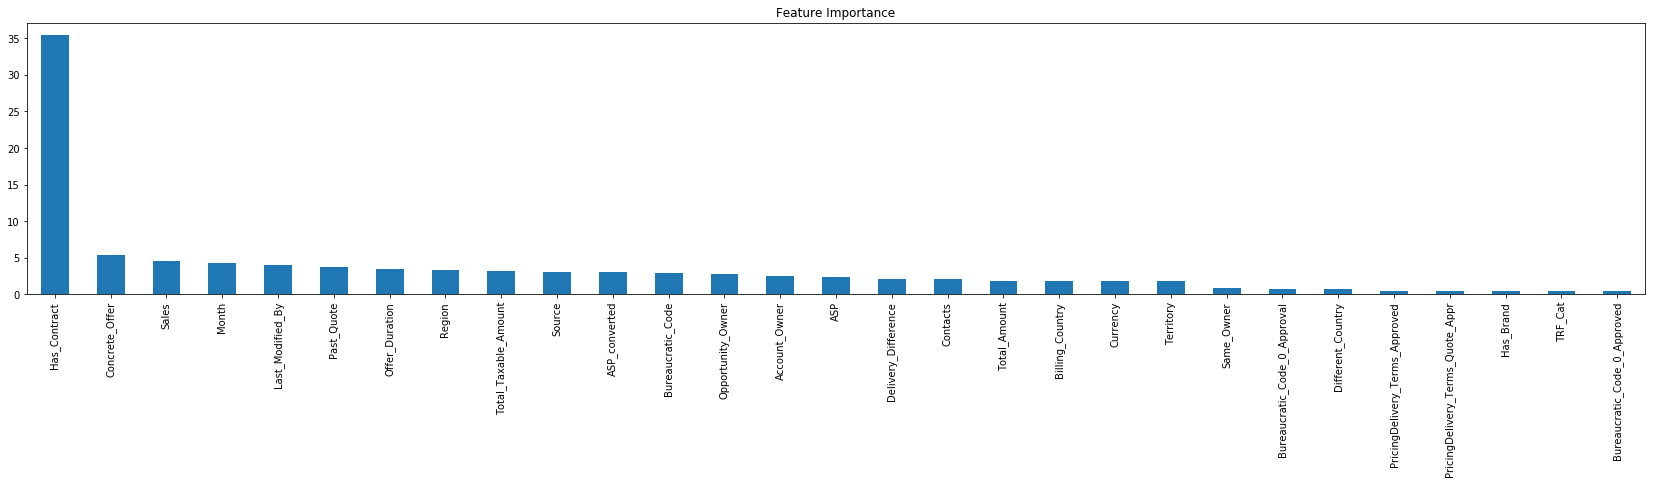

In [419]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
print len(predictors)
feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:29]
plt.rcParams['figure.figsize'] = 29, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [420]:
bad = x_test_pred[(x_test_pred.Prediction > 0.5) & (x_test_pred.Stage == 0) | (x_test_pred.Prediction < 0.5) & (x_test_pred.Stage == 1)]

In [421]:
bad.Stage.value_counts()

0    76
1    18
Name: Stage, dtype: int64

In [422]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model.predict_proba(validation.drop(leak, axis = 1))[:,1]

# agrupo por Opportunity_ID para dar una sola prediccion por solicitud

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
validation = validation.join(pred)

answer = pd.DataFrame(validation.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [423]:
prev = pd.read_csv("best/modellgbold_pred.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9919779617248335

In [424]:
prev = pd.read_csv("best/model_xgb_pred.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9924085528182642

In [425]:
prev = pd.read_csv("best/modelada_pred.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9933662540128385

In [426]:
prev = pd.read_csv("best/modelcat_pred.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9989658585528783

In [427]:
prev = pd.read_csv("best/avg_lgb_xgb_ada_cat.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9968210362348355

In [398]:
#answer.to_csv("acceptable/submission_29.csv", header = False, index = False)